<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-4/blob/main/Datathon_4_APACHEpredictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODEL WITH DECISION TREE**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
# from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data_clean.csv')

data = data.drop('Unnamed: 0',axis = 1)

# drop vitals vars
data_apache = data.drop(['age', 'gender', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_noninvasive_max',	'h1_sysbp_noninvasive_min',	'h1_temp_max', 'h1_temp_min',	'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache'],axis = 1)
data_apache.head()



,hospital_death,apache_4a_icu_death_prob,apache_2_diagnosis,apache_3j_diagnosis
0,0,0.00,122.0,703.03
1,0,0.02,301.0,403.01
2,0,0.06,113.0,501.05
3,0,0.01,112.0,107.01
4,0,0.01,301.0,403.01


In [3]:
# checking data types
data_apache.dtypes

hospital_death                int64
apache_4a_icu_death_prob    float64
apache_2_diagnosis          float64
apache_3j_diagnosis         float64
dtype: object

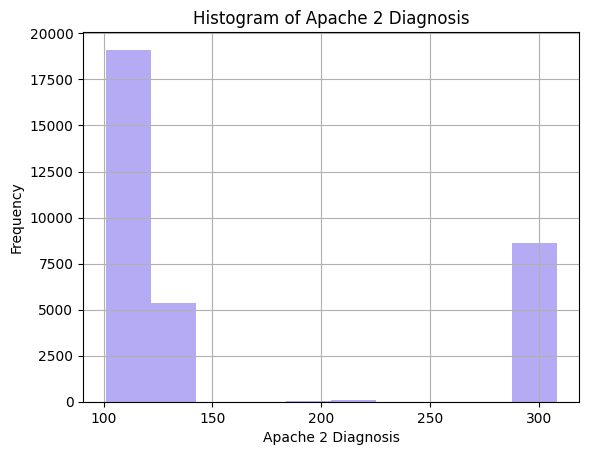

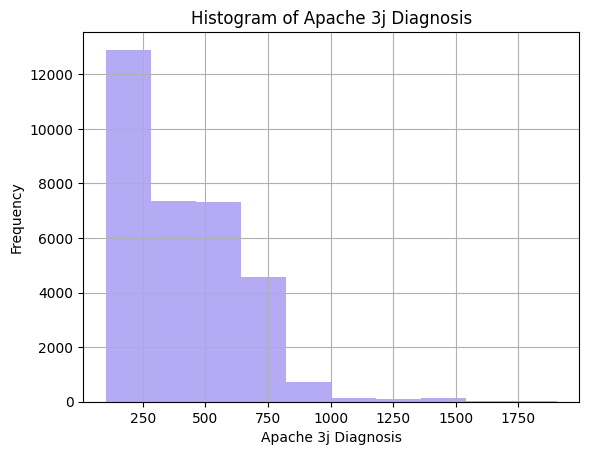

In [4]:
# Create a histogram for the apache_2_diagnosis column with a custom color
data_apache['apache_2_diagnosis'].hist(color='#b5abf5')  # Using a shade of blue as an example color
plt.xlabel('Apache 2 Diagnosis')  # Label for the x-axis
plt.ylabel('Frequency')     # Label for the y-axis
plt.title('Histogram of Apache 2 Diagnosis')  # Title for the histogram
plt.show()  # Display the histogram


# Create a histogram for the apache_3j_diagnosis column with a custom color
data_apache['apache_3j_diagnosis'].hist(color='#b5abf5')  # Using a shade of blue as an example color
plt.xlabel('Apache 3j Diagnosis')  # Label for the x-axis
plt.ylabel('Frequency')     # Label for the y-axis
plt.title('Histogram of Apache 3j Diagnosis')  # Title for the histogram
plt.show()  # Display the histogram

Apache 3j diagnosis scores seems to have a left-skewed distribution,
and Apache 2 diagnosis scores seems to have a U-shaped distribution

Data Preparation


---



In [5]:
# Convert float64 variables to integer type
data_apache['apache_2_diagnosis'] = data_apache['apache_2_diagnosis'].astype(int)
data_apache['apache_3j_diagnosis'] = data_apache['apache_3j_diagnosis'].astype(int)

In [6]:
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'


# List of columns that contain numerical data (excluding target column)
numerical_columns = ['apache_2_diagnosis', 'apache_3j_diagnosis']


In [10]:
# Splitting the data into 70% training and 30% testing
train = data_apache.sample(frac=0.7, random_state=10)
test = data_apache.drop(train.index)

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = train['hospital_death'].to_numpy()
Y_test = test['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = train.drop('hospital_death', axis=1).to_numpy()
X_test = test.drop('hospital_death', axis=1).to_numpy()

# Standardize features to have 0 mean and unit variance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Oversampling using SMOTE because our outcome is imbalanced, with continuous features
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print("After OverSampling, counts of label '1': {}".format(sum(Y_train_resampled == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train_resampled == 0)))



After OverSampling, counts of label '1': 21273
After OverSampling, counts of label '0': 21273


Initialize Decision Tree


---



In [12]:
# Initializing a Decision Tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

# Creating a pipeline that first preprocesses the data and then applies the decision tree
model = Pipeline([
        ('DT', dt)
])

# Training the model on the training data
model = model.fit(X_train_resampled, Y_train_resampled)

# Predicting and evaluating the model's performance on the training data
Y_pred_train_resampled = model.predict(X_train_resampled)
accuracy_score(Y_train_resampled, Y_pred_train_resampled)

0.8911531048747239

Hyperparameter tuning using grid search


---



In [13]:

# Define the hyperparameter values that should be tested
param_dist = {
    "DT__max_depth" : [5, 10, 15, 20 ,25, 30, 35],
    "DT__min_samples_leaf" : [5, 10, 15, 20 ,25],
    "DT__splitter" : ['best', 'random'],
    "DT__max_features" : ['sqrt', 'log2']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Train Grid Search on the training data
random_search.fit(X_train_resampled, Y_train_resampled)

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_DT__max_depth,param_DT__max_features,param_DT__min_samples_leaf,param_DT__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
110,0.03579,0.001567,0.002842,0.000216,30,log2,5,best,"{'DT__max_depth': 30, 'DT__max_features': 'log...",0.816334,0.867199,0.859913,0.868375,0.863556,0.855075,0.019596,1


In [14]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'DT__max_depth': 30,
 'DT__max_features': 'log2',
 'DT__min_samples_leaf': 5,
 'DT__splitter': 'best'}

In [17]:
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train_resampled, Y_train_resampled)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train_resampled)
train_accuracy = accuracy_score(Y_train_resampled, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_pred = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_pred)
print(test_accuracy)

0.8719973675551168
0.8358059342421812


# **MODEL WITH NEURAL NETS**

In [18]:
# importing necessary libraries
# !pip install torch

# importing torch as t
import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

Initializing Neural Network Parameters in PyTorch


---



In [51]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 2
hidden_units_layer_2 = 2

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((2, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

Implementing Forward Pass of Neural Network


---



In [52]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = relu(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = relu(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

Preparing Data and Training Utilities for NN Training


---



In [53]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train_resampled).type(t.float32)
Y = t.Tensor(Y_train_resampled).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

Training Loop for NN


---



In [54]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

RuntimeError: ignored